In [1]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift
import random
from matplotlib.colors import ListedColormap
from datetime import date, timedelta

sys.path.append("../..")

from utils.utils import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-07-18 18:49:01,317 INFO cyclops.orm     - Database setup, ready to run queries!


In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
threshold=0.000001
num_timesteps = 6
stat_window=30
lookup_window=30
stride=1
run=1
shift="covid"
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH","PMH"]
outcome="mortality"
aggregation_type="time"
scale=True

In [3]:
admin_data, x, y = get_gemini_data(PATH)

numerical_cols = get_numerical_cols(PATH)
for col in numerical_cols:
    scaler = StandardScaler().fit(x[col].values.reshape(-1, 1))
    x[col] = pd.Series(
        np.squeeze(scaler.transform(x[col].values.reshape(-1, 1))),
        index=x[col].index,
    )
X = reshape_inputs(x, num_timesteps)

2022-07-18 18:49:01,368 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-18 18:49:01,992 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-18 18:49:02,209 INFO cyclops.feature_handler - Loading features from file...
2022-07-18 18:49:02,211 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-18 18:49:02,212 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-18 18:49:02,244 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-18 18:49:07,512 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-18 18:49:17,144 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet
2022-07-18 18:49:36,929 INFO cyclops.feature_handler - Loading features from file...
2022-07-18 18:49:36,932 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-18 18:49:36,933 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-18 18:49:36,962 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-07-18 18:49:41,749 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


## Set constant reference distribution

In [38]:
# X_tr_final = np.load(os.path.join(PATH, shift, "X_train.npy"))
# X_val_final = np.load(os.path.join(PATH, shift, "X_val.npy"))
# X_t_final = np.load(os.path.join(PATH, shift, "X_test.npy"))

# y_train = np.load(os.path.join(PATH, shift, "y_train.npy"))
# y_val = np.load(os.path.join(PATH, shift, "y_val.npy"))
# y_test = np.load(os.path.join(PATH, shift, "y_test.npy"))

In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, shift, outcome, hospital, run, shuffle=True)

random.seed(1)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, num_timesteps, x_train, y_train, x_val, y_val, x_test, y_test)
# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, num_timesteps, X_tr_normalized, X_val_normalized, X_t_normalized)

## Create Data Streams

In [5]:
#####################################################
## a given date contains data from previous two weeks 
#####################################################

start_date = date(2019, 1, 1)
end_date = date(2020, 8, 1)

def daterange(start_date, end_date, stride, window):
    for n in range(int((end_date - start_date).days)):
        if start_date + timedelta(n*stride+window) < end_date:
            yield start_date+ timedelta(n*stride)
            

def get_streams(x, y, admin_data, start_date, end_date, stride, window, ids_to_exclude=None):
    target_stream_x = []
    target_stream_y = [] 
    measure_dates = []

    admit_df = admin_data[[ENCOUNTER_ID,ADMIT_TIMESTAMP]].sort_values(by=ADMIT_TIMESTAMP)
    for single_date in daterange(start_date, end_date, stride, window):
        if single_date.month ==1 and single_date.day == 1:
            print(single_date.strftime("%Y-%m-%d"),"-",(single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
        encounters_inwindow = admit_df.loc[((single_date+timedelta(days=window)).strftime("%Y-%m-%d") > admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d")) 
                           & (admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d") >= single_date.strftime("%Y-%m-%d")), ENCOUNTER_ID].unique()
        if ids_to_exclude is not None:
            encounters_inwindow = [x for x in encounters_inwindow if x not in ids_to_exclude]
        encounter_ids = x.index.get_level_values(0).unique()
        x_inwindow = x.loc[x.index.get_level_values(0).isin(encounters_inwindow)]
        y_inwindow = pd.DataFrame(y[np.in1d(encounter_ids, encounters_inwindow)])
        if not x_inwindow.empty:
            target_stream_x.append(x_inwindow)
            target_stream_y.append(y_inwindow)
            measure_dates.append((single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
    return(target_stream_x, target_stream_y, measure_dates)

val_ids=list(X_val_normalized.index.get_level_values(0).unique())

In [6]:
x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1, ids_to_exclude=val_ids)

2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Rolling Window

In [7]:
dr_technique="NoRed"
model_path=os.path.join(os.getcwd(),"../../saved_models/covid_lstm.pt")
md_test="Context-Aware MMD"
sign_level=0.05
sample=1000
dataset="gemini"
context_type="lstm"
representation=None

shift_reductor = ShiftReductor(
    X_tr_final, y_tr, dr_technique, orig_dims, dataset, var_ret=0.8, model_path=model_path,
)
# Get shift detector
shift_detector = ShiftDetector(
    dr_technique, md_test, sign_level, shift_reductor, sample, dataset, feats, model_path, context_type, representation,
)
            
#####################################################
## rolling window - not cumulatively including data and no adjustment made when drift occurs
##################################################### 
def rolling_window(X_train, X_stream, shift_detector, sample, stat_window, lookup_window, stride, num_timesteps, threshold, custom_ref=None):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    i = 0 

    if custom_ref is not None:
        X_prev = custom_ref
    
    while i+stat_window+lookup_window < len(X_stream):
        feat_index = 0
        
        if custom_ref is None:
            X_prev = pd.concat(X_stream[i:i+stat_window])
            X_prev = X_prev[~X_prev.index.duplicated(keep='first')]
            
        X_next = pd.concat(X_stream[i+lookup_window:i+lookup_window+stat_window])
        X_next = X_next[~X_next.index.duplicated(keep='first')]
        X_next = reshape_inputs(X_next, num_timesteps)
       
        if X_next.shape[0]<=2 or X_prev.shape[0]<=2:
            break
        
        (p_val, dist, val_acc, te_acc) = shift_detector.detect_data_shift(X_train, 
                                                                          X_prev[:sample,:], 
                                                                          X_next[:sample,:], 
                                                                          orig_dims,
        )
        
        if p_val < threshold:
            print("P-value below threshold.")
            print("Ref -->",i+lookup_window,"-",i+stat_window+lookup_window,"\tP-Value: ",p_val)
        dist_vals = np.concatenate((dist_vals, np.repeat(dist, 1)))
        p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
        i += stride
    return dist_vals, p_vals

In [8]:
dist_vals_test_covid, p_vals_test_covid = rolling_window(X_tr_final, x_test_stream, shift_detector, sample, stat_window, lookup_window, stride, num_timesteps, threshold, X_val_final)

P-value below threshold.
Ref --> 39 - 69 	P-Value:  0.0
P-value below threshold.
Ref --> 43 - 73 	P-Value:  0.0
P-value below threshold.
Ref --> 50 - 80 	P-Value:  0.0
P-value below threshold.
Ref --> 53 - 83 	P-Value:  0.0
P-value below threshold.
Ref --> 55 - 85 	P-Value:  0.0
P-value below threshold.
Ref --> 56 - 86 	P-Value:  0.0
P-value below threshold.
Ref --> 57 - 87 	P-Value:  0.0
P-value below threshold.
Ref --> 61 - 91 	P-Value:  0.0
P-value below threshold.
Ref --> 63 - 93 	P-Value:  0.0
P-value below threshold.
Ref --> 69 - 99 	P-Value:  0.0
P-value below threshold.
Ref --> 78 - 108 	P-Value:  0.0
P-value below threshold.
Ref --> 79 - 109 	P-Value:  0.0
P-value below threshold.
Ref --> 80 - 110 	P-Value:  0.0
P-value below threshold.
Ref --> 82 - 112 	P-Value:  0.0
P-value below threshold.
Ref --> 84 - 114 	P-Value:  0.0
P-value below threshold.
Ref --> 85 - 115 	P-Value:  0.0
P-value below threshold.
Ref --> 86 - 116 	P-Value:  0.0
P-value below threshold.
Ref --> 87 - 117

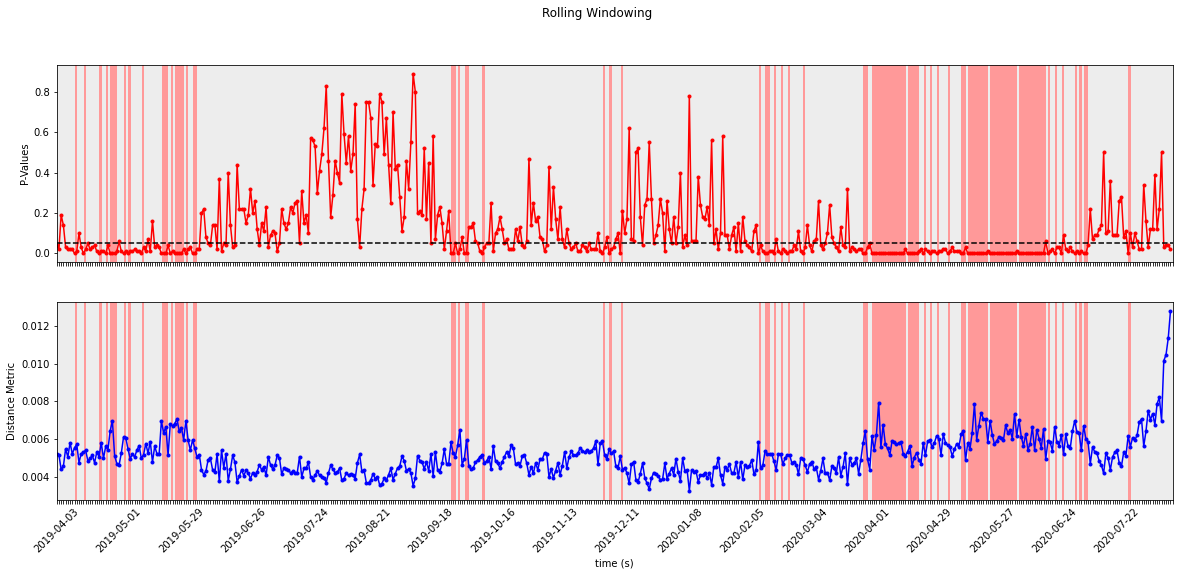

In [9]:
end = len(p_vals_test_covid)
measure_dates_test_covid = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_covid[1:end],
     'p_val_val': p_vals_test_covid[1:end],
     'dist metric_val': dist_vals_test_covid[1:end],
     'detection': np.where(p_vals_test_covid[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_covid[1:end], p_vals_test_covid[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_covid[1:end], dist_vals_test_covid[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Rolling window prediction performance

In [10]:
from drift_detection.baseline_models.temporal.pytorch.optimizer import Optimizer
from drift_detection.baseline_models.temporal.pytorch.utils import *

output_dim = 1
batch_size = 64
input_dim = X_tr_final.shape[2]
timesteps = X_tr_final.shape[1]
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 256
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False

device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
model_path=os.path.join(os.getcwd(),"../../saved_models/covid_lstm.pt")
model.load_state_dict(torch.load(model_path))
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
activation = nn.Sigmoid()
opt = Optimizer(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    activation=activation,
    lr_scheduler=lr_scheduler,
)

#####################################################
## rolling window - not cumulatively including data and no adjustment made when drift occurs
##################################################### 
def rolling_window_performance(X_stream, y_stream, opt, sample, stat_window, lookup_window, stride, num_timesteps, threshold, custom_ref=None):
    auroc = np.asarray([])
    accuracy = np.asarray([])
    auprc = np.asarray([])
    
    i = 0 

    if custom_ref is not None:
        X_prev = custom_ref
    
    while i+stat_window+lookup_window < len(X_stream):
        feat_index = 0
        
        if custom_ref is None:
            X_prev = pd.concat(X_stream[i:i+stat_window])
            X_prev = X_prev[~X_prev.index.duplicated(keep='first')]
            
        X_next = pd.concat(X_stream[i+lookup_window:i+lookup_window+stat_window])
        X_next = X_next[~X_next.index.duplicated(keep='first')]
        X_next = reshape_inputs(X_next, num_timesteps)
        
        y_next = pd.concat(y_stream[i+lookup_window:i+lookup_window+stat_window])
        y_next = y_next[~y_next.index.duplicated(keep='first')].to_numpy()
       
        if X_next.shape[0]<=2 or X_prev.shape[0]<=2:
            break
        
        test_dataset = get_data(X_next, y_next)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
            test_loader, batch_size=1, n_features=input_dim, timesteps=num_timesteps
        )

        y_pred_values = y_pred_values[y_test_labels != -1]
        y_pred_labels = y_pred_labels[y_test_labels != -1]
        y_test_labels = y_test_labels[y_test_labels != -1]

        pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels, verbose=0)
        auroc = np.concatenate((auroc, np.repeat(pred_metrics["auroc"], 1)))
        accuracy = np.concatenate((accuracy, np.repeat(pred_metrics["acc"], 1)))
        auprc = np.concatenate((auprc, np.repeat(pred_metrics["auprc"], 1)))
        
        i += stride
            
    return auroc, auprc, accuracy

In [11]:
auroc_test_covid, auprc_test_covid, accuracy_test_covid = rolling_window_performance(x_test_stream, y_test_stream, opt, sample, stat_window, lookup_window, stride, num_timesteps, threshold, X_val_final)

invalid value encountered in float_scalars
invalid value encountered in float_scalars
invalid value encountered in float_scalars
invalid value encountered in float_scalars
invalid value encountered in float_scalars
invalid value encountered in float_scalars


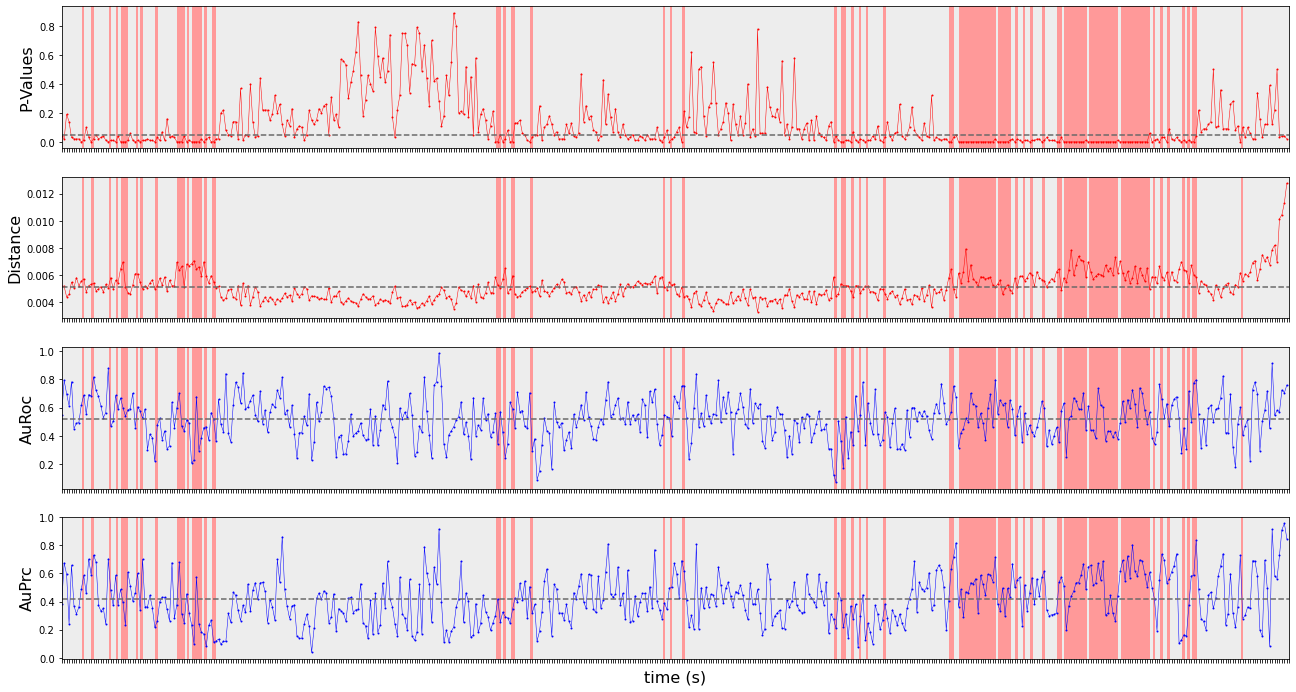

In [12]:
end = len(p_vals_test_covid)
measure_dates_test_covid = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(22,12))
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_covid[1:end],
     'p_val_val': p_vals_test_covid[1:end],
     'auroc_val': auroc_test_covid[1:end],
     'auprc_val': auprc_test_covid[1:end],
     'accuracy_val': accuracy_test_covid[1:end],
     'detection': np.where(p_vals_test_covid[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_covid[1:end], p_vals_test_covid[1:end], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax1.axhline(y=0.05, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
  
ax2.plot(measure_dates_test_covid[1:end], dist_vals_test_covid[1:end], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(dist_vals_test_covid), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)


ax3.plot(measure_dates_test_covid[1:end], auroc_test_covid[1:end], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax3.set_ylabel('AuRoc', fontsize=16)
ax3.axhline(y=np.mean(auroc_test_covid), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax4.plot(measure_dates_test_covid[1:end], auprc_test_covid[1:end], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(measure_dates_test_covid[1],measure_dates_test_covid[end])
ax4.set_ylabel('AuPrc',fontsize=16)
ax4.set_xlabel('time (s)', fontsize=16)
ax4.axhline(y=np.mean(auprc_test_covid), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax4.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()